<a href="https://colab.research.google.com/github/JamilePolycarpo/RedesNeurais-Imagem3D/blob/main/ImagemRedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install kaggle
 #caso seja necessário atualizar a biblioteca no google colab

from google.colab import files
files.upload() #enviar o arquivo kaggle.json

#antes de importar o dataset nós iremos provisionar o local de armazenamento
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle competitions download -c image-matching-challenge-2022
#Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip

In [7]:
import tensorflow as tf
import os

In [35]:
import cv2
import imghdr

#removendo fotos com extensões não compativeis
data_dir = 'train'

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):#percorrendo todas as pastas
  if os.path.isdir(image_class):
   for image in os.listdir(os.path.join(data_dir, image_class)): #percorrendo todas as fotos de todas as pastas
     image_path = os.path.join(data_dir,image_class,image)

     try:
       img = cv2.imread(image_path)
       tip = imghdr.what(image_path)
       if tip not in image_exts:
         print("Imagem não está na extensao certa{}".format(image_path))
         os.remove(image_path)
     except Exception as e:
       print("Problema com a imagem{}".format(image_path))



In [36]:
 import numpy as np
 from matplotlib import pyplot as plt

 #Load dataset

 data = tf.keras.utils.image_dataset_from_directory('train')
 data_iterator = data.as_numpy_iterator()
 batch = data_iterator.next()
 batch[0].shape
 batch[1]


Found 5678 files belonging to 16 classes.


array([15,  2,  0,  3,  2,  7,  0, 13, 12, 10, 13,  6, 15, 11,  0, 13,  2,
        1,  5, 13,  6, 13, 15,  8,  6, 12,  6, 11, 15,  5,  1, 15],
      dtype=int32)

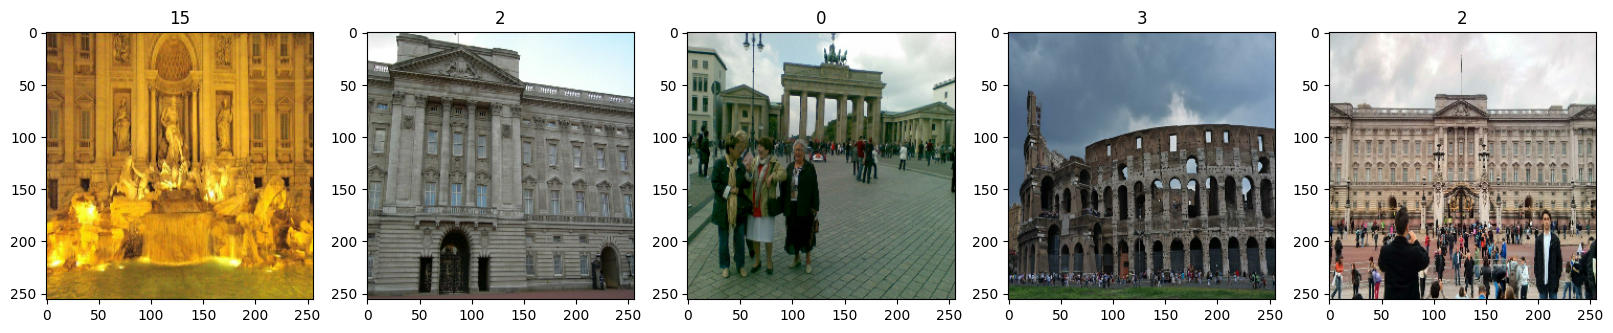

In [37]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20)) #checando numero das categorias com as imagens
for idx, img in enumerate(batch[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


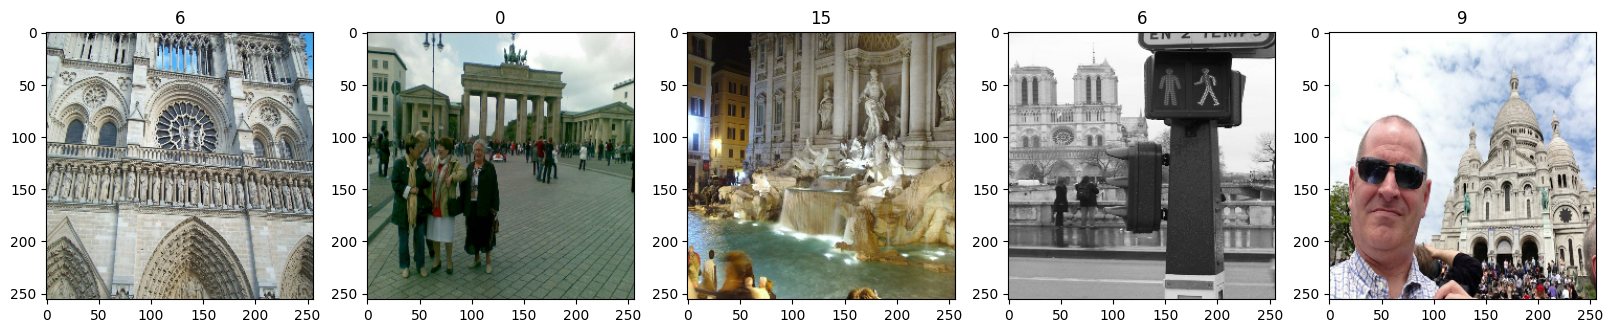

In [38]:
#Processando os dados
#escalonando as imagens

data= data.map(lambda x, y: (x/255, y)) #para o valor do rgb ficar entre 0 e 1
scaled_iterator = data.as_numpy_iterator()
batch= scaled_iterator.next()
batch[0].max()




In [45]:
#Dividindo entre treino, validacao e teste

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)





In [50]:
from logging import logProcesses
#Construindo a deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(16,(3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())


model.add(Conv2D(16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
#model.add(Dense(1, activatio='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 16)       

In [ ]:
#Treino

logdir= 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
124/124 [==============================] - 354s 3s/step - loss: -84.1394 - accuracy: 0.0000e+00 - val_loss: -85.8957 - val_accuracy: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 312s 3s/step - loss: -84.7093 - accuracy: 0.0000e+00 - val_loss: -87.4117 - val_accuracy: 0.0000e+00
Epoch 3/20
124/124 [==============================] - 303s 2s/step - loss: -84.9943 - accuracy: 0.0000e+00 - val_loss: -85.4379 - val_accuracy: 0.0000e+00
Epoch 4/20
124/124 [==============================] - ETA: 0s - loss: -85.2146 - accuracy: 0.0000e+00

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plot.show()
